In [1]:
# ! pip install git+https://github.com/catalyst-team/catalyst@dev --upgrade

In [2]:
# ! pip install scikit-learn>=0.20 optuna

###  Kittylyst demo

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
%matplotlib inline

In [4]:
from typing import *

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from catalyst import dl, metrics

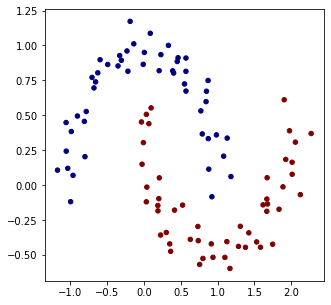

In [5]:
# make up a dataset
def make_dataset(seed=42, n_samples=100):
    np.random.seed(seed)
    random.seed(seed)
    X, y = make_moons(n_samples=100, noise=0.1)

    y = y*2 - 1 # make y be -1 or 1
    return X, y

def visualize_dataset(X, y):
    plt.figure(figsize=(5,5))
    plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

# let's create train data
X_train, y_train = make_dataset()
visualize_dataset(X_train, y_train)

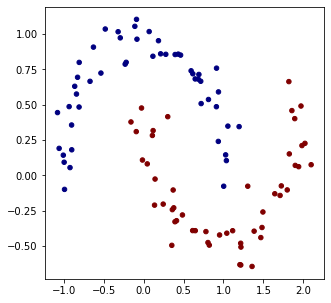

In [6]:
# valid data
X_valid, y_valid = make_dataset(seed=137)
visualize_dataset(X_valid, y_valid)

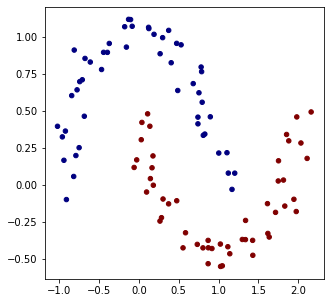

In [7]:
# and another train one (why not?)
X_train2, y_train2 = make_dataset(seed=1337)
visualize_dataset(X_train2, y_train2)

In [8]:
# initialize a model 
# 2-layer neural network
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
print(model)
# print("number of parameters", len(model.parameters()))

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [9]:
def visualize_decision_boundary(X, y, model):
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    
    inputs = torch.tensor([list(xrow) for xrow in Xmesh]).float()
    scores = model(inputs)
    
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
    return fig

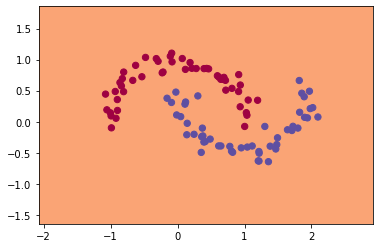

In [10]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

In [11]:
t1 = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train > 0).float())
t2 = TensorDataset(torch.tensor(X_train2).float(), torch.tensor(y_train2 > 0).float())
v1 = TensorDataset(torch.tensor(X_valid).float(), torch.tensor(y_valid > 0).float())

loaders = {
    "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
    "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
    "valid": DataLoader(v1, batch_size=32, num_workers=1), 
}

---

### Act 1 - ``CustomRunner`` solution

Suppose you have your favorite `for-loop` pipeline and want to get rid of `for-for-for` stuff to make code more clean. In this case you can define your own ``CustomRunner`` with ``_handle_batch`` method and just run it.

Whole ``Runner`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/runner.py) (~100 lines of code).

In [12]:
# 2-layer neural network
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
experiment = dl.SingleStageExperiment(
    model=model, 
    optimizer=optimizer, 
    loaders=loaders, 
    num_epochs=10
)

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)

        loss = F.binary_cross_entropy_with_logits(y_hat.view(-1), y)
        self.batch_metrics = {"loss": loss}
        print(
            f"{self.loader_key} ({self.loader_batch_step}/{self.loader_batch_len}:" 
            f"loss {loss.item()}"
        )

        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

CustomRunner().run(experiment)

train_1 (1/4:loss 0.7027437090873718
train_1 (2/4:loss 0.6653220057487488
train_1 (3/4:loss 0.6342369914054871
train_1 (4/4:loss 0.6342847347259521
train_2 (1/4:loss 0.5706769227981567
train_2 (2/4:loss 0.5537675023078918
train_2 (3/4:loss 0.5040708780288696
train_2 (4/4:loss 0.40751564502716064
valid (1/4:loss 0.44895756244659424
valid (2/4:loss 0.48384860157966614
valid (3/4:loss 0.4327024221420288
valid (4/4:loss 0.2789505422115326
train_1 (1/4:loss 0.43434619903564453
train_1 (2/4:loss 0.4163673222064972
train_1 (3/4:loss 0.4064352214336395
train_1 (4/4:loss 0.543968677520752
train_2 (1/4:loss 0.3810475170612335
train_2 (2/4:loss 0.389755517244339
train_2 (3/4:loss 0.3510582447052002
train_2 (4/4:loss 0.18909525871276855
valid (1/4:loss 0.31519120931625366
valid (2/4:loss 0.38233691453933716
valid (3/4:loss 0.3411101996898651
valid (4/4:loss 0.05796895548701286
train_1 (1/4:loss 0.3112953305244446
train_1 (2/4:loss 0.317863404750824
train_1 (3/4:loss 0.35042786598205566
train_1 (4/

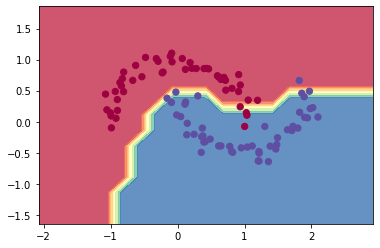

In [13]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 2 - ``SupervisedRunner`` solution

Let's make a bit more abstract. Let's introduce ``SupervisedRunner``, that knows how to execute Supervised models and ``CriterionCallback/OptimizerCallback/SchedulerCallback`` for typical criterions/optimizers/schedulers steps. 

Additionaly let's wrap accuracy with ``AccuracyCallback``, as far as metrics are general too. 

Finally, let's make our logs looks consistent with ``LoggerCallback``.

Whole ``Callback`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/callback.py) (~100 lines of code).

In [14]:
num_epochs=6
model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])

experiment = dl.SingleStageExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=num_epochs,
    callbacks={
        "criterion": dl.CriterionCallback(
            metric_key="loss", 
            outputs_key="logits", 
            targets_key="targets"
        ), 
#         "accuracy": dl.MetricCallback(
#             metric=metrics.AccuracyMetric(), compute_on_batch=True,
#             outputs_key="logits", targets_key="targets", 
#         ),
        "auc": dl.MetricCallback(
            metric=metrics.AUCMetric(), compute_on_batch=False,
            outputs_key="scores", targets_key="targets", 
        ), 
        "optimizer": dl.OptimizerCallback(metric_key="loss"), 
        "scheduler": dl.SchedulerCallback(
            loader_key="valid", metric_key="loss"
        ),
        "checkpoint1": dl.CheckpointCallback(
            loader_key="valid", metric_key="auc", 
            minimize=False, save_n_best=3
        ),
        "checkpoint2": dl.CheckpointCallback(
            loader_key="valid", metric_key="loss", 
            minimize=True, save_n_best=1
        ),
        "verbose": dl.VerboseCallback(),
    },
    loggers={
        "console": dl.ConsoleLogger(),
        "csv": dl.LogdirLogger(logdir="./logdir"),
    }
)

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

CustomRunner().run(experiment)

Hparams (experiment): {}



train_1 (1/6) auc: 0.8515999999999999 | loss: 0.6774069690704345 | loss/std: 0.015066117249995174



train_2 (1/6) auc: 0.9339999999999999 | loss: 0.5996801209449768 | loss/std: 0.02110312839622848



valid (1/6) auc: 0.9376 | loss: 0.5371240508556365 | loss/std: 0.02091185827401528
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (2/6) auc: 0.9339999999999999 | loss: 0.507241485118866 | loss/std: 0.02993508835862766



train_2 (2/6) auc: 0.9299999999999999 | loss: 0.434192498922348 | loss/std: 0.05112486468824183



valid (2/6) auc: 0.9408 | loss: 0.37482650578022003 | loss/std: 0.04658968369059159
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (3/6) auc: 0.9384000000000001 | loss: 0.36489189863204957 | loss/std: 0.021639398504284493



train_2 (3/6) auc: 0.9467999999999999 | loss: 0.3225413328409195 | loss/std: 0.029789896667858907



valid (3/6) auc: 0.9583999999999999 | loss: 0.278597872108221 | loss/std: 0.05048417260202923
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (4/6) auc: 0.958 | loss: 0.2806558620929718 | loss/std: 0.039492878708056324



train_2 (4/6) auc: 0.9552 | loss: 0.28739032268524173 | loss/std: 0.02197123820994376



valid (4/6) auc: 0.96 | loss: 0.2722929693758488 | loss/std: 0.04989590070791587
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (5/6) auc: 0.9612 | loss: 0.2741867971420288 | loss/std: 0.03812901279789116



train_2 (5/6) auc: 0.9564 | loss: 0.28132986307144164 | loss/std: 0.02255802845089023



valid (5/6) auc: 0.9624 | loss: 0.2665697357058525 | loss/std: 0.04826460572939384
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth



train_1 (6/6) auc: 0.9628 | loss: 0.2685170793533325 | loss/std: 0.03525054773807415



train_2 (6/6) auc: 0.9584 | loss: 0.27606665432453154 | loss/std: 0.02339177378207804



valid (6/6) auc: 0.9656 | loss: 0.26132327303290365 | loss/std: 0.04653452148474865
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth
Top-N best epochs:
6	0.9656
5	0.9624
4	0.9600
checkpoint loaded from  ./logpath.pth
Top-N best epochs:
6	0.2613
checkpoint loaded from  ./logpath.pth


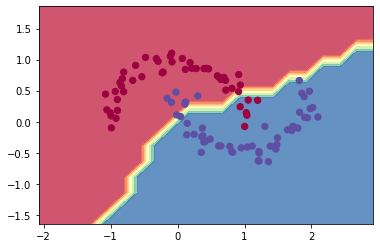

In [15]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

---

### Act 3 - ``CustomExperiment`` solution - multi-stage experiment with ``VisualizationCallback``

Let's go even harder. Suppose we want to firstly train our model on `train_1` data, and only after that - on `train_2`. This case could be easily handled with ``CustomExperiment``, where you could redefine your experiment components for each stage of your experiment.

Whole ``Experiemnt`` source code is located [here](github.com/Scitator/kittylyst/blob/master/kittylyst/experiment.py) (~100 lines of code).

In [16]:
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [17]:
class CustomExperiment(dl.SingleStageExperiment):
    @property
    def stages(self):
        return self._stage

    def get_loaders(self, stage: str):
        return self._loaders[stage]

    
# class VisualizationCallback(ICallback):
#     def on_epoch_end(self, runner):
#         img = visualize_decision_boundary(X_valid, y_valid, runner.model)
#         img = get_img_from_fig(img)
#         runner.log_image(img, scope="epoch")

        
loaders = {
    "stage_1": {
        "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
        "valid": DataLoader(v1, batch_size=32, num_workers=1), 
    },
    "stage_2": {
        "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
        "valid": DataLoader(v1, batch_size=32, num_workers=1), 
    },
}
stages = loaders.keys()
num_epochs=10

model = nn.Sequential(
    nn.Linear(2, 16), nn.ReLU(), 
    nn.Linear(16, 16), nn.ReLU(), 
    nn.Linear(16, 1)
)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])

experiment = CustomExperiment(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    loaders=loaders, 
    num_epochs=num_epochs,
    callbacks={
        "criterion": dl.CriterionCallback(
            metric_key="loss", 
            outputs_key="logits", 
            targets_key="targets"
        ), 
#         "accuracy": dl.MetricCallback(
#             metric=metrics.AccuracyMetric(), compute_on_batch=True,
#             outputs_key="logits", targets_key="targets", 
#         ),
        "auc": dl.MetricCallback(
            metric=metrics.AUCMetric(), compute_on_batch=False,
            outputs_key="scores", targets_key="targets", 
        ), 
        "optimizer": dl.OptimizerCallback(metric_key="loss"), 
        "scheduler": dl.SchedulerCallback(
            loader_key="valid", metric_key="loss"
        ),
        "checkpoint1": dl.CheckpointCallback(
            loader_key="valid", metric_key="auc", 
            minimize=False, save_n_best=3
        ),
        "checkpoint2": dl.CheckpointCallback(
            loader_key="valid", metric_key="loss", 
            minimize=True, save_n_best=1
        ),
#         "visualization": VisualizationCallback(),
#         "verbose": VerboseCallback(),
        
    },
    loggers={
#         "console": ConsoleLogger(exclude=["batch", "global_batch", "loader", "global_epoch"]),
        "console": dl.ConsoleLogger(),
        "csv": dl.LogdirLogger(logdir="./logdir2"),
    },
    stage=stages  # <-- here is the trick for multi-stage support
)

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

CustomRunner().run(experiment)

Hparams (experiment): {}
train_1 (1/10) auc: 0.628 | loss: 0.6842921042442323 | loss/std: 0.016516368242907815
valid (1/10) auc: 0.9099999999999999 | loss: 0.6321618318557739 | loss/std: 0.012280290277671588
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth
train_1 (2/10) auc: 0.9184 | loss: 0.6048205184936524 | loss/std: 0.009740330591301373
valid (2/10) auc: 0.9276 | loss: 0.5470819795131683 | loss/std: 0.02274503484738651
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth
train_1 (3/10) auc: 0.9299999999999999 | loss: 0.5178400063514709 | loss/std: 0.0312879205471755
valid (3/10) auc: 0.9387999999999999 | loss: 0.46028956055641174 | loss/std: 0.03841862532952897
checkpoint saved at  ./logpath.pth
checkpoint saved at  ./logpath.pth
train_1 (4/10) auc: 0.9376 | loss: 0.45551621437072753 | loss/std: 0.02197758033922405
valid (4/10) auc: 0.9403999999999999 | loss: 0.4515323770046234 | loss/std: 0.03913547489077512
checkpoint saved at  ./logpath.pth

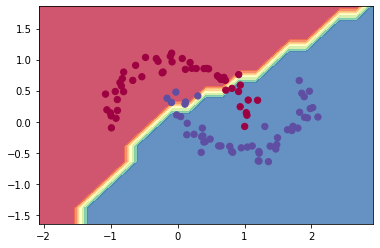

In [18]:
_ = visualize_decision_boundary(X_valid, y_valid, model)

### Act 4 - integration with hyperparameter search

In [19]:
from datetime import datetime
import optuna    

class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }

def objective(trial):
    num_epochs = 6
    num_hidden1 = int(trial.suggest_loguniform("num_hidden1", 2, 16))
    num_hidden2 = int(trial.suggest_loguniform("num_hidden2", 2, 16))
    
    loaders = {
        "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
        "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
        "valid": DataLoader(v1, batch_size=32, num_workers=1), 
    }

    model = nn.Sequential(
        nn.Linear(2, num_hidden1), nn.ReLU(), 
        nn.Linear(num_hidden1, num_hidden2), nn.ReLU(), 
        nn.Linear(num_hidden2, 1)
    )
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])

    experiment = dl.SingleStageExperiment(
        model=model, 
        criterion=criterion, 
        optimizer=optimizer, 
        scheduler=scheduler,
        loaders=loaders, 
        num_epochs=num_epochs,
        callbacks={
            "criterion": dl.CriterionCallback(
                metric_key="loss", 
                outputs_key="logits", 
                targets_key="targets"
            ), 
    #         "accuracy": dl.MetricCallback(
    #             metric=metrics.AccuracyMetric(), compute_on_batch=True,
    #             outputs_key="logits", targets_key="targets", 
    #         ),
            "auc": dl.MetricCallback(
                metric=metrics.AUCMetric(), compute_on_batch=False,
                outputs_key="scores", targets_key="targets", 
            ), 
            "optimizer": dl.OptimizerCallback(metric_key="loss"), 
            "scheduler": dl.SchedulerCallback(
                loader_key="valid", metric_key="loss"
            ),
            "checkpoint": dl.CheckpointCallback(
                loader_key="valid", metric_key="auc", 
                minimize=False, save_n_best=3
            ),
            "optuna": dl.OptunaPruningCallback(loader_key="valid", metric_key="auc")
        },
        loggers={
            "console": dl.ConsoleLogger(),
            "csv": dl.LogdirLogger(logdir=f"./logdir/{datetime.now().strftime('%Y%m%d-%H%M%S')}"),
        },
        trial=trial,
#         hparams={"l2_alpha": l2_alpha, "num_hidden1": num_hidden1, "num_hidden2": num_hidden2},
    )

    runner = CustomRunner()
    runner.run(experiment)
    score = runner.callbacks["checkpoint"].top_best_metrics[0][0]
    
    return score

study = optuna.create_study(
    direction="maximize",
#     direction="minimize",
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=0, n_warmup_steps=0, interval_steps=1
    ),
)
study.optimize(objective, n_trials=5, timeout=300)
print(study.best_value, study.best_params)

[I 2021-01-17 16:52:44,044] A new study created in memory with name: no-name-4c7b1dd5-c396-4f72-84db-8a8980c2345c


Hparams (experiment_0): {'num_hidden1': 2.761997594823678, 'num_hidden2': 9.72483793811465}
train_1 (1/6) auc: 0.5780000000000001 | loss: 0.6883243703842163 | loss/std: 0.011628435933964275
train_2 (1/6) auc: 0.9132 | loss: 0.655271770954132 | loss/std: 0.006331745217386827
valid (1/6) auc: 0.9348 | loss: 0.6399168920516968 | loss/std: 0.007825030181124031
checkpoint saved at  ./logpath.pth
train_1 (2/6) auc: 0.9364 | loss: 0.631259491443634 | loss/std: 0.01661744476319952
train_2 (2/6) auc: 0.9292 | loss: 0.6057998633384705 | loss/std: 0.030444191038366732
valid (2/6) auc: 0.9408 | loss: 0.5829337763786316 | loss/std: 0.017351456637400862
checkpoint saved at  ./logpath.pth
train_1 (3/6) auc: 0.942 | loss: 0.5712852954864502 | loss/std: 0.0266123626751145
train_2 (3/6) auc: 0.9396000000000001 | loss: 0.5291743898391723 | loss/std: 0.039003344192764564
valid (3/6) auc: 0.9472 | loss: 0.49050491213798525 | loss/std: 0.02557715768168956
checkpoint saved at  ./logpath.pth
train_1 (4/6) auc

[I 2021-01-17 16:52:44,867] Trial 0 finished with value: 0.9504000000000001 and parameters: {'num_hidden1': 2.761997594823678, 'num_hidden2': 9.72483793811465}. Best is trial 0 with value: 0.9504000000000001.


valid (6/6) auc: 0.9504000000000001 | loss: 0.4547371196746826 | loss/std: 0.028140226312307243
checkpoint saved at  ./logpath.pth
Top-N best epochs:
6	0.9504
4	0.9476
3	0.9472
checkpoint loaded from  ./logpath.pth
Hparams (experiment_1): {'num_hidden1': 5.490615699167159, 'num_hidden2': 2.1903269946213744}
train_1 (1/6) auc: 0.6619999999999999 | loss: 0.6901086235046386 | loss/std: 0.01353323125075377
train_2 (1/6) auc: 0.9252 | loss: 0.6736936521530151 | loss/std: 0.006652376806197365
valid (1/6) auc: 0.9511999999999999 | loss: 0.6598608684539795 | loss/std: 0.004599762703191457
checkpoint saved at  ./logpath.pth
train_1 (2/6) auc: 0.9491999999999999 | loss: 0.6496525812149048 | loss/std: 0.005924665063334266
train_2 (2/6) auc: 0.9400000000000001 | loss: 0.618720154762268 | loss/std: 0.025934615270053456
valid (2/6) auc: 0.9452 | loss: 0.5938200616836548 | loss/std: 0.018099757632110355
train_1 (3/6) auc: 0.9436 | loss: 0.5781680560112 | loss/std: 0.036370992687410605
train_2 (3/6) a

[I 2021-01-17 16:52:45,721] Trial 1 finished with value: 0.9511999999999999 and parameters: {'num_hidden1': 5.490615699167159, 'num_hidden2': 2.1903269946213744}. Best is trial 1 with value: 0.9511999999999999.


valid (6/6) auc: 0.9432 | loss: 0.5086305296421051 | loss/std: 0.04147060071793489
Top-N best epochs:
1	0.9512
checkpoint loaded from  ./logpath.pth
Hparams (experiment_2): {'num_hidden1': 3.4707530033047034, 'num_hidden2': 4.187129206842507}
train_1 (1/6) auc: 0.10000000000000002 | loss: 0.7118435835838317 | loss/std: 0.00847532381445367
train_2 (1/6) auc: 0.6856 | loss: 0.6909527039527893 | loss/std: 0.0065233907750102665


[I 2021-01-17 16:52:45,862] Trial 2 pruned. Trial was pruned at epoch 1.


valid (1/6) auc: 0.9036 | loss: 0.6885535502433776 | loss/std: 0.0010180478729150228
checkpoint saved at  ./logpath.pth
Hparams (experiment_3): {'num_hidden1': 5.353913943454244, 'num_hidden2': 2.035244278814365}
train_1 (1/6) auc: 0.6244 | loss: 0.7086496782302857 | loss/std: 0.05102535448349446
train_2 (1/6) auc: 0.83 | loss: 0.6895477843284608 | loss/std: 0.03632326117253451


[I 2021-01-17 16:52:46,006] Trial 3 pruned. Trial was pruned at epoch 1.


valid (1/6) auc: 0.9168000000000001 | loss: 0.6756574797630309 | loss/std: 0.01173598642357526
checkpoint saved at  ./logpath.pth
Hparams (experiment_4): {'num_hidden1': 10.780180709147158, 'num_hidden2': 4.442494802624502}
train_1 (1/6) auc: 0.6672 | loss: 0.6892907762527466 | loss/std: 0.033834700280784835
train_2 (1/6) auc: 0.8704000000000001 | loss: 0.63555006980896 | loss/std: 0.018434203375285188


[I 2021-01-17 16:52:46,159] Trial 4 pruned. Trial was pruned at epoch 1.


valid (1/6) auc: 0.8768 | loss: 0.5932668209075928 | loss/std: 0.016376209615087848
checkpoint saved at  ./logpath.pth
0.9511999999999999 {'num_hidden1': 5.490615699167159, 'num_hidden2': 2.1903269946213744}


### Act 5 - fully custom experiment

In [20]:
class CustomExperiment(dl.IExperiment):
    @property
    def seed(self) -> int:
        return 73

    @property
    def name(self) -> str:
        # @TODO: auto-generate name?
        return "experiment73"

    @property
    def hparams(self) -> Dict:
        return {}

    @property
    def stages(self) -> List[str]:
        return ["stage_1", "stage_2"]

    def get_stage_params(self, stage: str) -> Dict[str, Any]:
        if stage == "stage_1":
            return {
                "num_epochs": 10,
                "migrate_model_from_previous_stage": False,
                "migrate_callbacks_from_previous_stage": False,
            }
        elif stage == "stage_2":
            return {
                "num_epochs": 6,
                "migrate_model_from_previous_stage": True,
                "migrate_callbacks_from_previous_stage": False,
            }
        else:
            raise NotImplemented()

    def get_loaders(self, stage: str) -> Dict[str, Any]:
        if stage == "stage_1":
            return {
                "train_1": DataLoader(t1, batch_size=32, num_workers=1), 
                "valid": DataLoader(v1, batch_size=32, num_workers=1), 
            }
        elif stage == "stage_2":
            return {
                "train_2": DataLoader(t2, batch_size=32, num_workers=1), 
                "valid": DataLoader(v1, batch_size=32, num_workers=1), 
            }
        else:
            raise NotImplemented()

    def get_model(self, stage: str):
        return nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(), 
            nn.Linear(16, 16), nn.ReLU(), 
            nn.Linear(16, 1)
        )

    def get_criterion(self, stage: str):
        return nn.BCEWithLogitsLoss()

    def get_optimizer(self, stage: str, model):
        if stage == "stage_1":
            return torch.optim.Adam(model.parameters(), lr=0.02)
        elif stage == "stage_2":
            return torch.optim.SGD(model.parameters(), lr=0.01)
        else:
            raise NotImplemented()

    def get_scheduler(self, stage: str, optimizer):
        if stage == "stage_1":
            return torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 8])
        elif stage == "stage_2":
            return torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])
        else:
            raise NotImplemented()
        

    def get_callbacks(self, stage: str) -> Dict[str, dl.Callback]:
        if stage == "stage_1":
            
            return {
                "criterion": dl.CriterionCallback(
                    metric_key="loss", 
                    outputs_key="logits", 
                    targets_key="targets"
                ), 
#                 "accuracy": dl.MetricCallback(
#                     metric=metrics.AccuracyMetric(), compute_on_batch=True,
#                     outputs_key="logits", targets_key="targets", 
#                 ),
#                 "auc": dl.MetricCallback(
#                     metric=metrics.AUCMetric(), compute_on_batch=False,
#                     outputs_key="scores", targets_key="targets", 
#                 ), 
                "optimizer": dl.OptimizerCallback(metric_key="loss"), 
                "scheduler": dl.SchedulerCallback(
                    loader_key="valid", metric_key="loss"
                ),
                "checkpoint": dl.CheckpointCallback(
                    loader_key="valid", metric_key="loss", 
                    minimize=True, save_n_best=3
                ),
            }
        elif stage == "stage_2":
            return {
                "criterion": dl.CriterionCallback(
                    metric_key="loss", 
                    outputs_key="logits", 
                    targets_key="targets"
                ), 
                "auc": dl.MetricCallback(
                    metric=metrics.AUCMetric(), compute_on_batch=False,
                    outputs_key="scores", targets_key="targets", 
                ), 
                "optimizer": dl.OptimizerCallback(metric_key="loss"), 
                "scheduler": dl.SchedulerCallback(
                    loader_key="valid", metric_key="loss"
                ),
                "checkpoint_auc": dl.CheckpointCallback(
                    loader_key="valid", metric_key="auc", 
                    minimize=False, save_n_best=3
                ),
            }
        else:
            raise NotImplemented()
        

    def get_engine(self):
        return dl.Engine()

    def get_trial(self):
        return None

    def get_loggers(self):
        return {
            "console": dl.ConsoleLogger(),
            "csv": dl.LogdirLogger(logdir="./logdir5"),
        }

    
class CustomRunner(dl.IStageBasedRunner):
    def handle_batch(self, batch):
        x, y = batch
        y_hat = self.model(x)
        
        self.batch = {
            "features": x,
            "targets": y,
            "logits": y_hat.view(-1),
            "scores": torch.sigmoid(y_hat.view(-1)),
        }
    
experiment = CustomExperiment()
CustomRunner().run(experiment)

Hparams (experiment73): {}
train_1 (1/10) loss: 0.6554987812042237 | loss/std: 0.010964926683879592
valid (1/10) loss: 0.592820405960083 | loss/std: 0.013404487100205743
checkpoint saved at  ./logpath.pth
train_1 (2/10) loss: 0.5644180583953857 | loss/std: 0.019220165048759556
valid (2/10) loss: 0.49304522514343263 | loss/std: 0.02807273757878892
checkpoint saved at  ./logpath.pth
train_1 (3/10) loss: 0.4591502058506012 | loss/std: 0.029442021060177036
valid (3/10) loss: 0.3757249855995178 | loss/std: 0.03750348035124905
checkpoint saved at  ./logpath.pth
train_1 (4/10) loss: 0.3698853898048401 | loss/std: 0.012937625416118191
valid (4/10) loss: 0.36558716416358944 | loss/std: 0.0377596294729329
checkpoint saved at  ./logpath.pth
train_1 (5/10) loss: 0.3602266240119934 | loss/std: 0.01471463446294061
valid (5/10) loss: 0.3560610342025757 | loss/std: 0.03785174363952334
checkpoint saved at  ./logpath.pth
train_1 (6/10) loss: 0.351167676448822 | loss/std: 0.016884154862839472
valid (6/10

---

🎉 You have passed ``Kittylyst`` tutorial! This is just a minimal educational demo, but I hope you found it interesting for your deep learning research code organisation.

For more advanced and production-ready solution please follow our [Catalyst](https://github.com/catalyst-team/catalyst) repository.

PS. If you are interested in deep learning you could also try out our [dl-course](https://github.com/catalyst-team/dl-course).